In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import glob
import os
import sklearn.model_selection


In [2]:

metadata = pd.read_csv('metadata.csv')
metadata = metadata[['isic_id','age_approx','clin_size_long_diam_mm','sex','diagnosis_1']]
# encode columns
metadata['sex'] = metadata['sex'].map({'male': 0, 'female': 1})
metadata['diagnosis_1'] = metadata['diagnosis_1'].map({'Benign': 0, 'Malignant': 1})

# missing values
metadata['age_approx'] = metadata['age_approx'].fillna(metadata['age_approx'].mean())
metadata['clin_size_long_diam_mm'] = metadata['clin_size_long_diam_mm'].fillna(metadata['clin_size_long_diam_mm'].mean())
metadata = metadata.dropna()

# Create filename field
metadata['filename'] = metadata['isic_id'].astype(str) + '.jpg'


/var/folders/0b/33n254b510726mq07nrfcfbw0000gn/T/ipykernel_61978/695260491.py:1: DtypeWarning: Columns (6,9,10,11,13,14,15,16,17,18,19,22,23,25,26,27,28,30,35) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('metadata.csv')


In [3]:
metadata.head()

,isic_id,age_approx,clin_size_long_diam_mm,sex,diagnosis_1,filename
0,ISIC_9536278,45.0,3.988203,1.0,1.0,ISIC_9536278.jpg
1,ISIC_7650956,65.0,3.988203,1.0,1.0,ISIC_7650956.jpg
2,ISIC_5730927,85.0,3.988203,0.0,1.0,ISIC_5730927.jpg
3,ISIC_4305055,85.0,3.988203,1.0,1.0,ISIC_4305055.jpg
4,ISIC_5681611,85.0,3.988203,1.0,1.0,ISIC_5681611.jpg


In [4]:
'''
good_image_paths = []

for path in valid_image_paths:
    try:
        img_raw = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img_raw, channels=3)
        good_image_paths.append(path)
    except:
        print(f"Skipping invalid image: {path}")

with open('good_image_paths.txt', 'w') as f:
    for path in good_image_paths:
        f.write(f"{path}\n")
'''

'\ngood_image_paths = []\n\nfor path in valid_image_paths:\n    try:\n        img_raw = tf.io.read_file(path)\n        img = tf.image.decode_jpeg(img_raw, channels=3)\n        good_image_paths.append(path)\n    except:\n        print(f"Skipping invalid image: {path}")\n\nwith open(\'good_image_paths.txt\', \'w\') as f:\n    for path in good_image_paths:\n        f.write(f"{path}\n")\n'

In [5]:
with open('good_image_paths.txt', 'r') as f:
    image_paths = [line.strip() for line in f]

filenames = [os.path.basename(p) for p in image_paths]
metadata = metadata[metadata['filename'].isin(filenames)].reset_index(drop=True)


In [6]:
# Create lookup dictionaries
label_lookup = dict(zip(metadata['filename'], metadata['diagnosis_1']))


# Lists for matched data
valid_image_paths = []
labels = []

for path, fname in zip(image_paths, filenames):
    if fname in label_lookup:
        valid_image_paths.append(path)
        labels.append(label_lookup[fname])


In [7]:
trainval_paths, test_paths, trainval_labels, test_labels = sklearn.model_selection.train_test_split(
    valid_image_paths, labels,
    test_size=0.1, random_state=42, shuffle=True
)


In [8]:
len(trainval_paths)

436973

In [26]:
from collections import defaultdict
import numpy as np
import shutil
import os

# Group filenames by class
label_to_paths = defaultdict(list)
for path, label in zip(trainval_paths, trainval_labels):
    label_to_paths[label].append(path)

# Set seed for reproducibility
np.random.seed(42)

# Define counts
# Training set: 10,000 total, 9600 benign, 400 malignant
train_benign = 9600
train_malignant = 400

# Validation set: 1000 total, 960 benign, 40 malignant
val_benign = 960
val_malignant = 40

# Sample training data
train_paths = []
train_labels = []

benign_train = np.random.choice(label_to_paths[0], train_benign, replace=False)
malignant_train = np.random.choice(label_to_paths[1], train_malignant, replace=False)

train_paths.extend(benign_train)
train_labels.extend([0] * train_benign)

train_paths.extend(malignant_train)
train_labels.extend([1] * train_malignant)

# Remove selected training files from pool before val sampling
label_to_paths[0] = list(set(label_to_paths[0]) - set(benign_train))
label_to_paths[1] = list(set(label_to_paths[1]) - set(malignant_train))

#sample validation data 
val_paths = []
val_labels = []

benign_val = np.random.choice(label_to_paths[0], val_benign, replace=False)
malignant_val = np.random.choice(label_to_paths[1], val_malignant, replace=False)

val_paths.extend(benign_val)
val_labels.extend([0] * val_benign)

val_paths.extend(malignant_val)
val_labels.extend([1] * val_malignant)

# create directories
for folder in ['images_train_realistic', 'images_val_realistic']:
    os.makedirs(folder, exist_ok=True)

# copy files
for path in train_paths:
    shutil.copy(path, f'images_train_realistic/{os.path.basename(path)}')

for path in val_paths:
    shutil.copy(path, f'images_val_realistic/{os.path.basename(path)}')


In [10]:

import os
import shutil
os.makedirs('./images_test', exist_ok=True)

for path in test_paths:
    filename = os.path.basename(path)
    shutil.copy(path, f'./images_test/{filename}')


In [27]:


train_image_ds = tf.keras.utils.image_dataset_from_directory(
    directory='images_train_realistic',
    labels=train_labels,
    label_mode='int',
    batch_size=64,
    image_size=(128, 128),
    shuffle=True,
    seed=123
)

val_image_ds = tf.keras.utils.image_dataset_from_directory(
    directory='images_val_realistic',
    labels=val_labels,
    label_mode='int',
    batch_size=64,
    image_size=(128, 128),
    shuffle=True,
    seed=123
)

Found 10000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [28]:
# Test filenames and labels
test_path_to_label = {os.path.basename(p): l for p, l in zip(test_paths, test_labels)}
test_filenames = [os.path.basename(p) for p in test_paths]
test_labels_sorted = [test_path_to_label[fname] for fname in test_filenames]

test_image_ds = tf.keras.utils.image_dataset_from_directory(
    directory='./images_test',
    labels=test_labels_sorted,
    label_mode='int',
    batch_size=64,
    image_size=(128, 128),
    shuffle=False
)


Found 48553 files belonging to 2 classes.


In [15]:

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the base model
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

# Add custom classification head
inputs = Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)  # Binary classification
model = Model(inputs, outputs)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train top layers first
history = model.fit(train_image_ds,
                    validation_data=val_image_ds,
                    epochs=20,
                    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

# Unfreeze and fine-tune
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-tune the whole model
history_finetune = model.fit(train_image_ds,
                             validation_data=val_image_ds,
                             epochs=50,
                             callbacks=[EarlyStopping(patience=20, restore_best_weights=True)])


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 146ms/step - accuracy: 0.9410 - loss: 0.2083 - val_accuracy: 0.9600 - val_loss: 0.1724
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - accuracy: 0.9630 - loss: 0.1600 - val_accuracy: 0.9600 - val_loss: 0.1735
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 147ms/step - accuracy: 0.9638 - loss: 0.1549 - val_accuracy: 0.9600 - val_loss: 0.1752
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 151ms/step - accuracy: 0.9629 - loss: 0.1582 - val_accuracy: 0.9600 - val_loss: 0.1753
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 153ms/step - accuracy: 0.9621 - loss: 0.1599 - val_accuracy: 0.9600 - val_loss: 0.1715
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 148ms/step - accuracy: 0.9637 - loss: 0.1585 - val_accuracy: 0.9600 - val_loss: 0.1716
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 151ms/step - accuracy: 0.9629 - loss: 0.1569 - val_accuracy: 0.9600 - val_loss: 0.1744
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 149ms/step - accuracy: 0.9634 - loss: 0

In [18]:
y_pred_probs = model.predict(test_image_ds)
y_pred = np.round(y_pred_probs).astype(int)

759/759 ━━━━━━━━━━━━━━━━━━━━ 100s 131ms/step


In [19]:
y_true = np.array(test_labels_sorted)

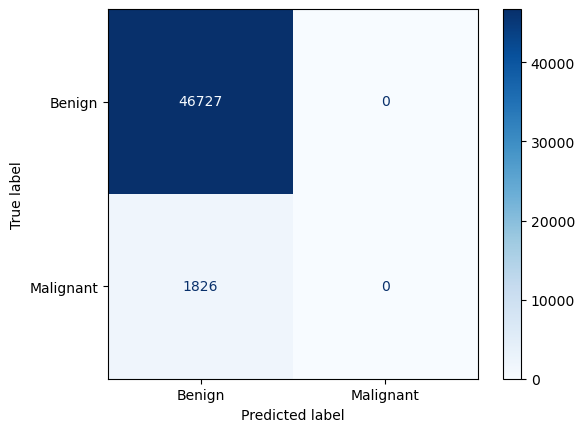

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues',values_format='d')


In [21]:
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98     46727
   Malignant       0.00      0.00      0.00      1826

    accuracy                           0.96     48553
   macro avg       0.48      0.50      0.49     48553
weighted avg       0.93      0.96      0.94     48553



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2025-05-12 17:55:17.761212: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


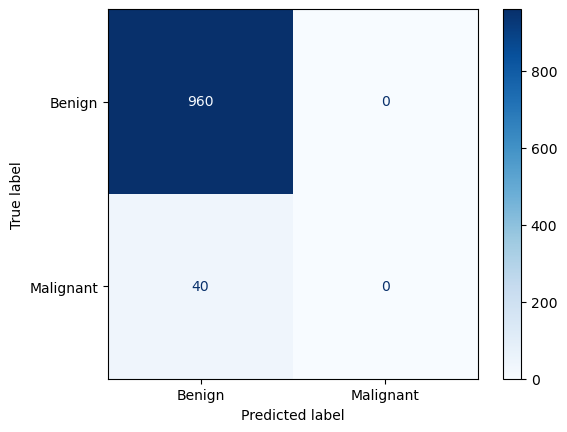

In [22]:
import matplotlib.pyplot as plt
y_true = []
y_pred = []

# Loop through the shuffled dataset in the same order used for prediction
for images, labels in val_image_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.round(preds).astype(int).flatten())  # or np.argmax if softmax
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues', values_format='d')
plt.show()

In [23]:
test_loss, test_accuracy = model.evaluate(val_image_ds)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 0.9599 - loss: 0.2671


In [24]:
model.save('model_5000_unbal.keras')